# IBD kinematics

The first step is to transform the original neutrino energy to the energy deposition (prompt signal only).

We aim to calculate the response function $f(E_{\mathrm{dep}} | E_{\nu})$

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")
plt.rcParams.update(
    {
        "figure.figsize": (6.4, 4.8),
        "figure.dpi": 600,
        "font.family": "serif",
        "font.size": 15,
        # 'figure.dpi': 300,
        "lines.linewidth": 2.0,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "xtick.major.size": 8,
        "xtick.minor.size": 4,
        "ytick.major.size": 8,
        "ytick.minor.size": 4,
        "xtick.major.width": 1,
        "xtick.minor.width": 0.7,
        "ytick.major.width": 1,
        "ytick.minor.width": 0.7,
        "xtick.direction": "in",
        "ytick.direction": "in",
        "legend.loc": "upper center",
        "legend.fancybox": True,  # if True, use a rounded box for the
        # legend background, else a rectangle
        "legend.fontsize": 15,
        "text.usetex": True,
    }
)

In [3]:
class StrumiaVissani:
    def __init__(self):
        # --- Constants (MeV) ---
        self.G_F = 1.16637e-11  # MeV^-2
        self.cos_theta_c = 0.97367  # PDG 2024
        self.m_p = 938.272
        self.m_n = 939.565
        self.m_e = 0.510999
        self.m_pi = 139.570
        self.alpha = 1.0 / 137.036
        self.M = (self.m_p + self.m_n) / 2.0
        self.Delta = self.m_n - self.m_p
        self.delta = (self.m_n**2 - self.m_p**2 - self.m_e**2) / 2 / self.m_p
        self.hbar_c = (
            scipy.constants.hbar * scipy.constants.c / scipy.constants.e / 1e4
        )  # MeV*cm

        # Form Factors
        self.M_V2 = 0.71 * 1e6  # MeV^2
        self.M_A2 = 1.026**2 * 1e6  # MeV^2
        self.g_1_0 = -1.27  # g_1 at t=0
        self.mu_p = 2.79284734463  # Proton magnetic moment, CODATA 2022
        self.mu_n = -1.91304276  # Neutron magnetic moment, CODATA 2022
        self.xi = self.mu_p - self.mu_n - 1.0  # Anomalous magnetic moment difference

    def get_kinematic_bounds(self, E_nu):
        """
        Calculates the kinematic bounds for the outgoing positron energy E_e given the incoming neutrino energy E_nu.

        Parameters:
        ---------
        E_nu : float or array-like
            Incoming neutrino energy in MeV.

        Returns:
        ---------
        E_e_min : float or array-like
            Minimum outgoing positron energy in MeV.
        E_e_max : float or array-like
            Maximum outgoing positron energy in MeV.
        """
        # First check if E_nu is above threshold
        E_nu = np.atleast_1d(E_nu)
        E_nu_threshold = ((self.m_n + self.m_e) ** 2 - self.m_p**2) / (2 * self.m_p)
        below_threshold = E_nu < E_nu_threshold

        # Calculate using Eq. 12 from Strumia-Vissani
        # Skip below-threshold values
        E_e_min = np.zeros_like(E_nu)
        E_e_max = np.zeros_like(E_nu)
        E_nu_valid = E_nu[~below_threshold]
        s = self.m_p**2 + 2 * self.m_p * E_nu_valid
        E_nu_cm = (s - self.m_p**2) / (2 * np.sqrt(s))
        E_e_cm = (s - self.m_n**2 + self.m_e**2) / (2 * np.sqrt(s))
        p_e_cm = np.sqrt(E_e_cm**2 - self.m_e**2)
        E_e_min[~below_threshold] = (
            E_nu_valid - self.delta - E_nu_cm * (E_e_cm + p_e_cm) / self.m_p
        )
        E_e_max[~below_threshold] = (
            E_nu_valid - self.delta - E_nu_cm * (E_e_cm - p_e_cm) / self.m_p
        )
        return E_e_min, E_e_max

    def calc_ABC(self, t, f1, f2, g1, g2):
        """
        Calculates A, B, C coefficients using Eq. 6 from Strumia-Vissani.
        Note: The inputs f1, f2, g1, g2 are real.

        Parameters:
        ----------
        t : float or array-like
            Mandelstam variable t (MeV^2).
        f1, f2, g1, g2 : float or array-like
            Form factors at momentum transfer t.

        Returns:
        -------
        A, B, C : float or array-like
            Coefficients for the matrix element calculation.
        """
        me2 = self.m_e**2
        M2 = self.M**2
        Delta2 = self.Delta**2

        # Term 16A:
        group1_inner = (
            4 * f1**2 * (4 * M2 + t + me2)
            + 4 * g1**2 * (-4 * M2 + t + me2)
            + f2**2 * (t**2 / M2 + 4 * t + 4 * me2)
            + (4 * me2 * t * g2**2) / M2
            + 8 * f1 * f2 * (2 * t + me2)
            + 16 * me2 * g1 * g2
        )
        term1 = (t - me2) * group1_inner

        group2_inner = (
            (4 * f1**2 + t * f2**2 / M2) * (4 * M2 + t - me2)
            + 4 * g1**2 * (4 * M2 - t + me2)
            + (4 * me2 * g2**2 * (t - me2)) / M2
            + 8 * f1 * f2 * (2 * t - me2)
            + 16 * me2 * g1 * g2
        )
        term2 = -Delta2 * group2_inner

        term3 = -32 * me2 * self.M * self.Delta * g1 * (f1 + f2)

        A = (term1 + term2 + term3) / 16.0

        # Term 16B:
        termB_num = (
            16 * t * g1 * (f1 + f2)
            + (4 * me2 * self.Delta * (f2**2 + f1 * f2 + 2 * g1 * g2)) / self.M
        )
        B = termB_num / 16.0

        # Term 16C:
        termC_num = 4 * (f1**2 + g1**2) - (t * f2**2) / M2
        C = termC_num / 16.0

        return A, B, C

    def differential_cross_section(self, E_nu, E_e):
        """
        Calculates the differential cross section dsigma/dE_e for IBD using the exact Strumia-Vissani formula (Eq. 11).

        Parameters:
        ----------
        E_nu : float
            Incoming neutrino energy in MeV.
        E_e : float
            Outgoing positron energy in MeV.

        Returns:
        -------
        dsigma_dE_corrected : float
            Differential cross section in cm^2/MeV.
        """
        # Kinematic bounds check
        E_nu = np.atleast_1d(E_nu)
        E_e = np.atleast_1d(E_e)
        E_nu, E_e = np.broadcast_arrays(
            E_nu, E_e
        )  # Ensure they can be broadcast together
        E_e_min, E_e_max = self.get_kinematic_bounds(E_nu)
        kinematic_mask = (
            (E_e >= E_e_min)
            & (E_e <= E_e_max)
            & (E_nu >= ((self.m_n + self.m_e) ** 2 - self.m_p**2) / (2 * self.m_p))
        )

        # As usual, we skip out-of-bounds values
        E_nu_valid = E_nu[kinematic_mask]
        E_e_valid = E_e[kinematic_mask]
        dsigma_dE_corrected = np.zeros_like(E_e)
        if E_nu_valid.size == 0:
            return dsigma_dE_corrected

        # Mandelstam variables
        s = self.m_p**2 + 2 * self.m_p * E_nu_valid
        s_minus_u = 2 * self.m_p * (E_nu_valid + E_e_valid) - self.m_e**2
        t = self.m_n**2 - self.m_p**2 - 2 * self.m_p * (E_nu_valid - E_e_valid)

        # Form Factors
        t_div_MV2 = t / self.M_V2
        t_div_MA2 = t / self.M_A2
        DV = 1.0 / (1 - t_div_MV2) ** 2
        DA = 1.0 / (1 - t_div_MA2) ** 2

        tau = t / (4 * self.M**2)
        f1 = DV * (1 - (1 + self.xi) * tau) / (1 - tau)
        f2 = DV * self.xi / (1 - tau)
        g1 = self.g_1_0 * DA
        g2 = 2 * self.M**2 * g1 / (self.m_pi**2 - t)

        # Get Exact A, B, C
        A, B, C = self.calc_ABC(t, f1, f2, g1, g2)

        # Calculate Matrix Element
        M2 = A - s_minus_u * B + s_minus_u**2 * C

        # Differential Cross Section, Eq. 5
        dsigma_dt = (
            (self.G_F**2 * self.cos_theta_c**2)
            / (2 * np.pi * (s - self.m_p**2) ** 2)
            * M2
        )
        # Eq. 11 includes a factor of 2*m_p
        dsigma_dE = 2 * self.m_p * dsigma_dt

        # Radiative Correction
        rad = 1.0 + (self.alpha / np.pi) * (
            6.0
            + 1.5 * np.log(self.m_p / (2 * E_e_valid))
            + 1.2 * (self.m_e / E_e_valid) ** 1.5
        )

        # Sommerfeld Correction is not needed for IBD
        # eta = 2 * np.pi * self.alpha / np.sqrt(1 - (self.m_e / E_e_valid)**2)
        # sommerfeld = eta / (1 - np.exp(-eta))

        # Finally, transform to cm^2
        dsigma_dE_corrected[kinematic_mask] = dsigma_dE * rad * (self.hbar_c) ** 2
        return dsigma_dE_corrected

    def get_E_dep_pdf(self, E_nu, E_dep):
        """
        Calculates the probability density function (PDF) of deposited energy E_dep for a given incoming neutrino energy E_nu.

        Parameters:
        ----------
        E_nu : float
            Incoming neutrino energy in MeV.
        E_dep : array-like
            Deposited energy array in MeV.

        Returns:
        -------
        pdf : array-like
            Probability density function values corresponding to E_dep.
        """
        E_nu = np.atleast_1d(E_nu)
        E_dep = np.atleast_1d(E_dep)
        # E_nu, E_dep = np.broadcast_arrays(E_nu, E_dep) # Ensure they can be broadcast together
        sigma = self.differential_cross_section(E_nu, E_dep - self.m_e)

        # Normalize by the total cross section
        sigma_total = self.get_total_cross_section(E_nu)

        if sigma_total == 0:
            pdf = np.zeros_like(E_dep)
        else:
            pdf = sigma / sigma_total
        return pdf

    def get_total_cross_section(self, E_nu):
        """
        Calculates the total cross section for IBD by integrating the differential cross section over allowed positron energies.

        Parameters:
        ----------
        E_nu : float or array-like
            Incoming neutrino energy in MeV.

        Returns:
        -------
        total_sigma : float or array-like
            Total cross section in cm^2.
        """
        E_nu = np.atleast_1d(E_nu)
        E_min, E_max = self.get_kinematic_bounds(E_nu)
        # Use scipy.integrate.quad for better accuracy
        total_sigma = np.zeros_like(E_nu)
        for i, E_nu_val in enumerate(np.atleast_1d(E_nu)):
            E_min_val, E_max_val = E_min[i], E_max[i]
            if E_max_val <= E_min_val:
                total_sigma[i] = 0.0
                continue
            total_sigma[i], abs_error = scipy.integrate.quad(
                lambda E_e: self.differential_cross_section(E_nu_val, E_e),
                E_min_val,
                E_max_val,
            )
            if total_sigma[i] > 0 and abs_error / total_sigma[i] > 1e-5:
                print(
                    f"Warning: High relative error in integration: {abs_error / total_sigma[i]:.2e}"
                )
        return total_sigma

E_nu=3.0 MeV: Left/Right Height Ratio = 1.195, Average Energy = 2.212 MeV
E_nu=4.0 MeV: Left/Right Height Ratio = 1.189, Average Energy = 3.205 MeV
E_nu=5.0 MeV: Left/Right Height Ratio = 1.179, Average Energy = 4.197 MeV


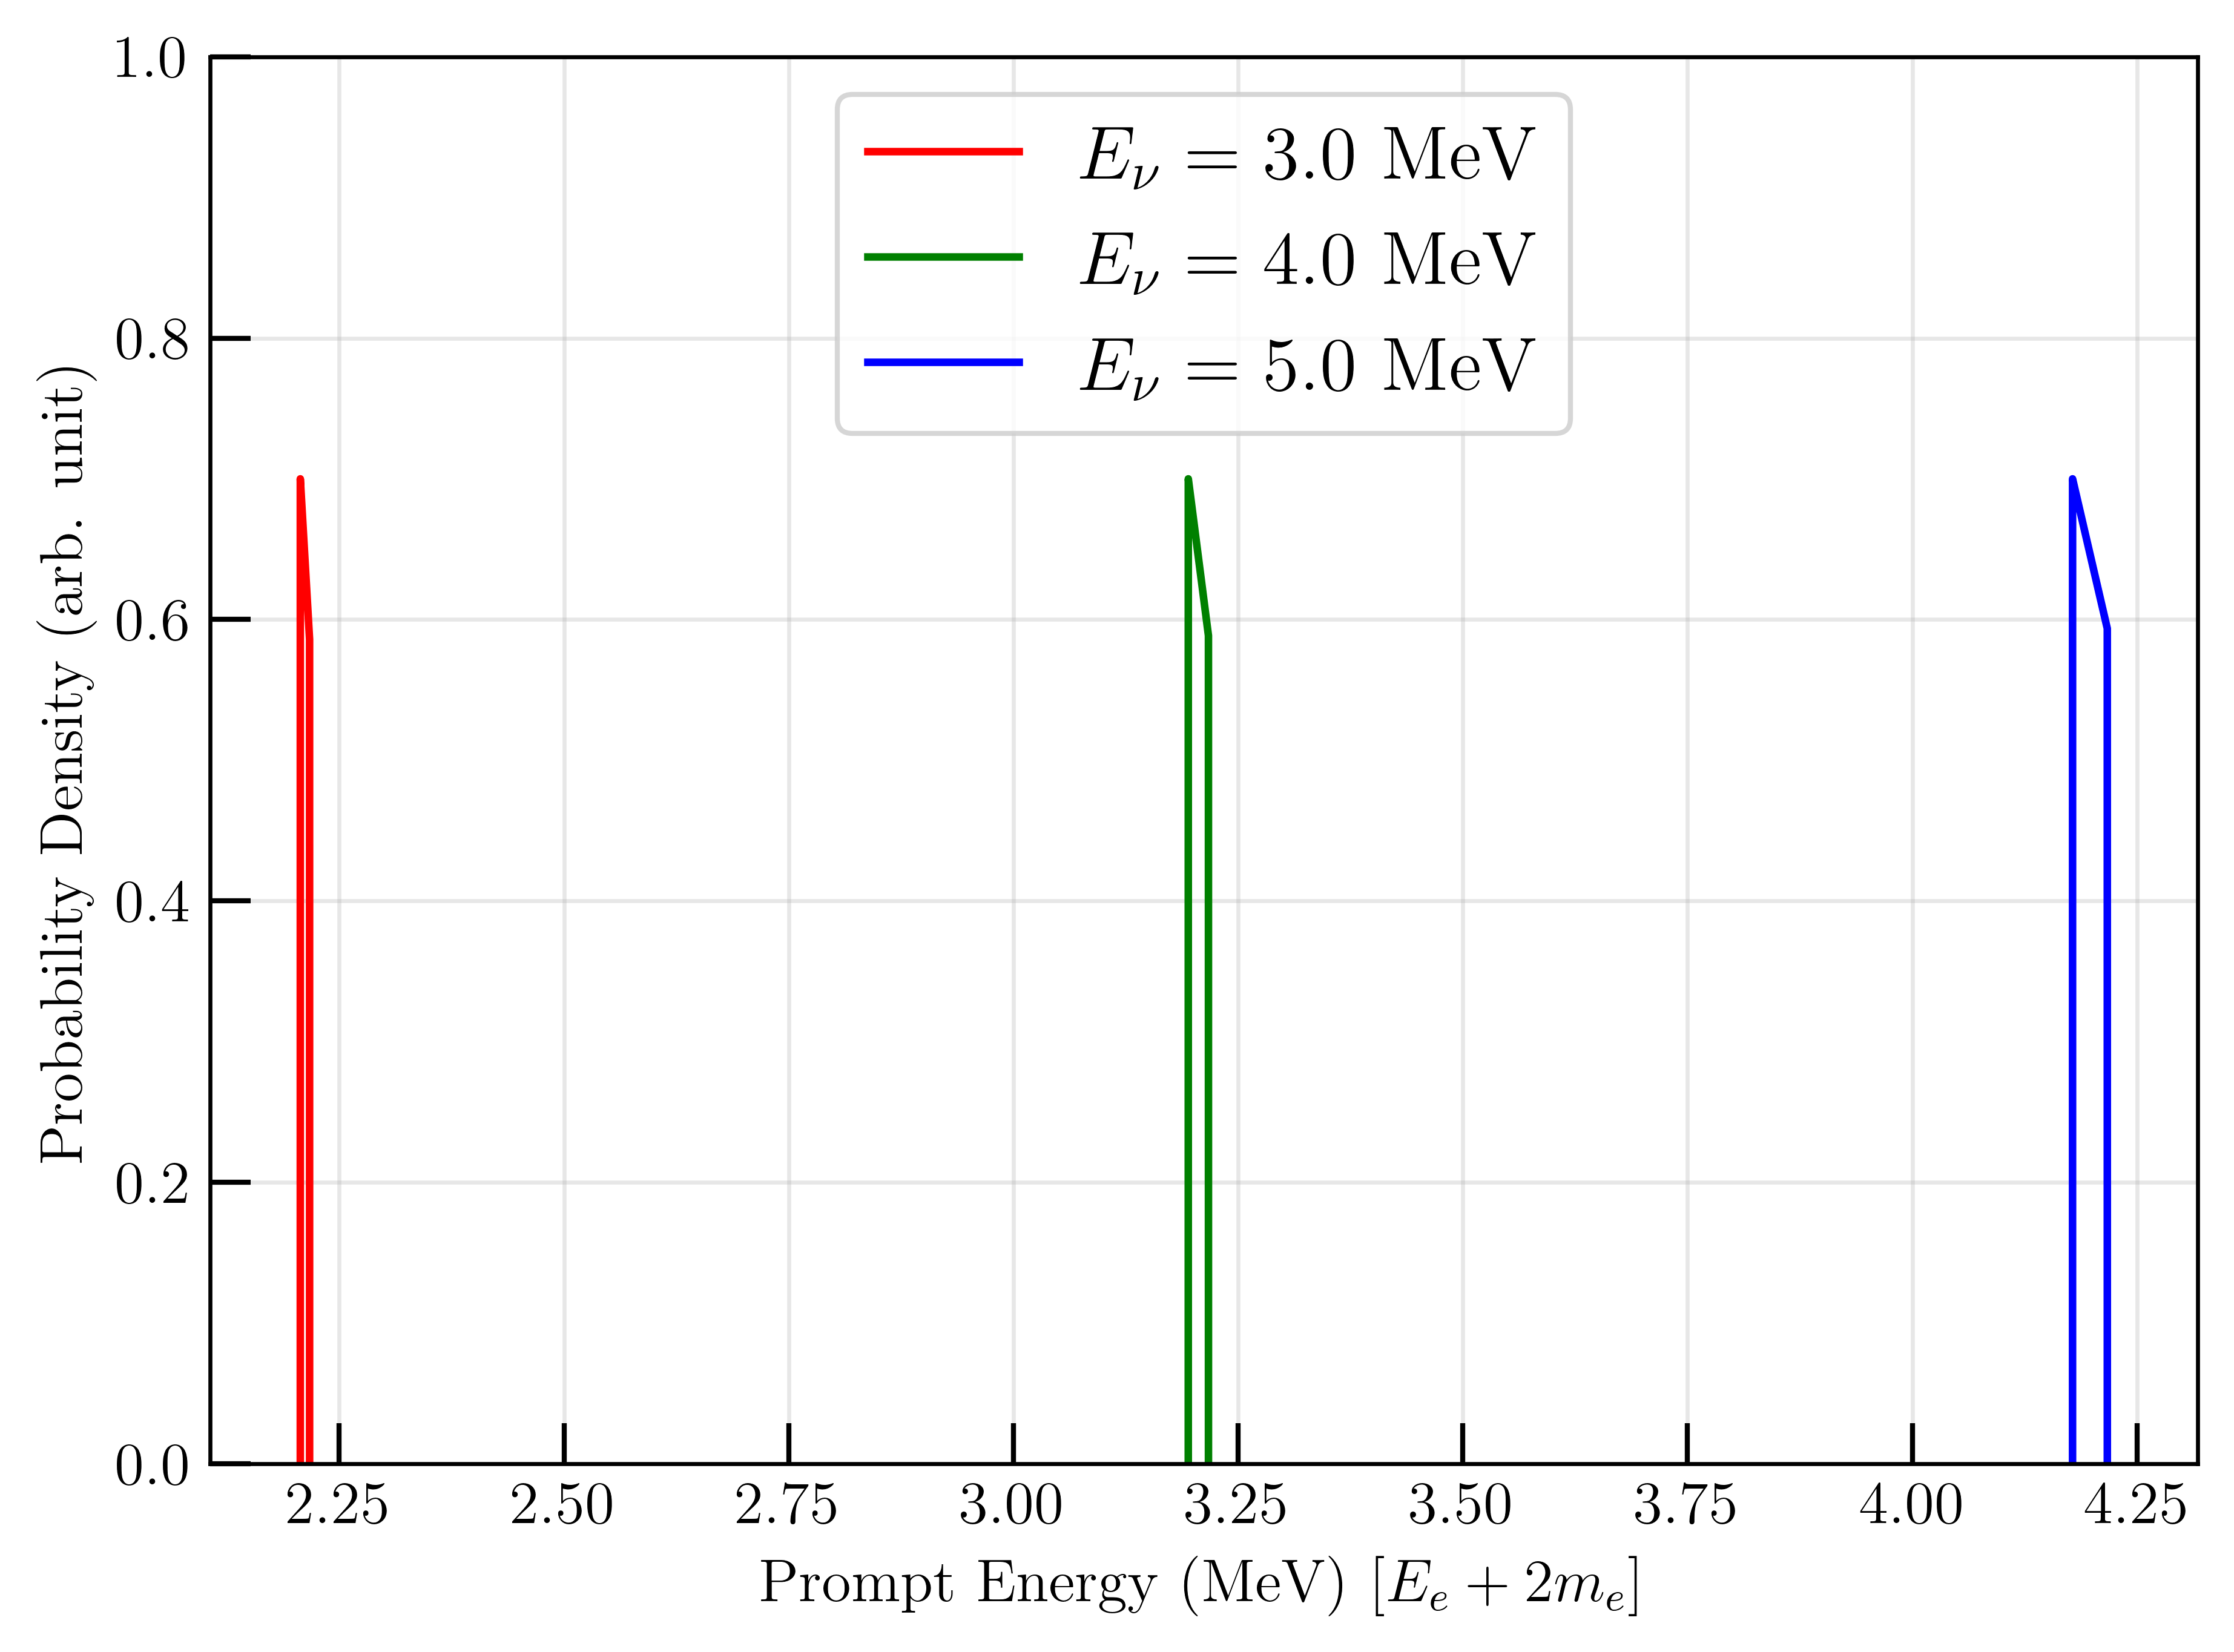

In [16]:
# Verify against the f(E_dep | E_nu) plot in JUNO
sv_exact = StrumiaVissani()

energies = [3.0, 4.0, 5.0]
colors = ["red", "green", "blue"]

# plt.figure(figsize=(10, 6))

for E, col in zip(energies, colors):
    E_min, E_max = sv_exact.get_kinematic_bounds(E)
    E_dep = np.linspace(E_min[0] - 1e-10, E_max[0] + 1e-10, 1000) + sv_exact.m_e
    pdf = sv_exact.get_E_dep_pdf(E, E_dep)

    # Calculate Drop Ratio to verify sharpness
    drop_ratio = pdf[1] / pdf[-2]
    average_energy = np.trapz(E_dep * pdf, E_dep) / np.trapz(pdf, E_dep)
    print(
        f"E_nu={E} MeV: Left/Right Height Ratio = {drop_ratio:.3f}, Average Energy = {average_energy:.3f} MeV"
    )

    plt.plot(
        E_dep, pdf / np.max(pdf) * 0.7, label=f"$E_\\nu={E}$ MeV", color=col, lw=1.5
    )
plt.ylim(0.0, 1.0)
# plt.title(
#     r"Energy Deposition $f(E_{dep} | E_{\nu})$ (Exact Strumia-Vissani Eq. 6)",
#     fontsize=14,
# )
plt.xlabel("Prompt Energy (MeV) [$E_e + 2m_e$]", fontsize=12)
plt.ylabel("Probability Density (arb. unit)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("./plots/ibd_energy_deposition_strumia_vissani.pdf", bbox_inches="tight")

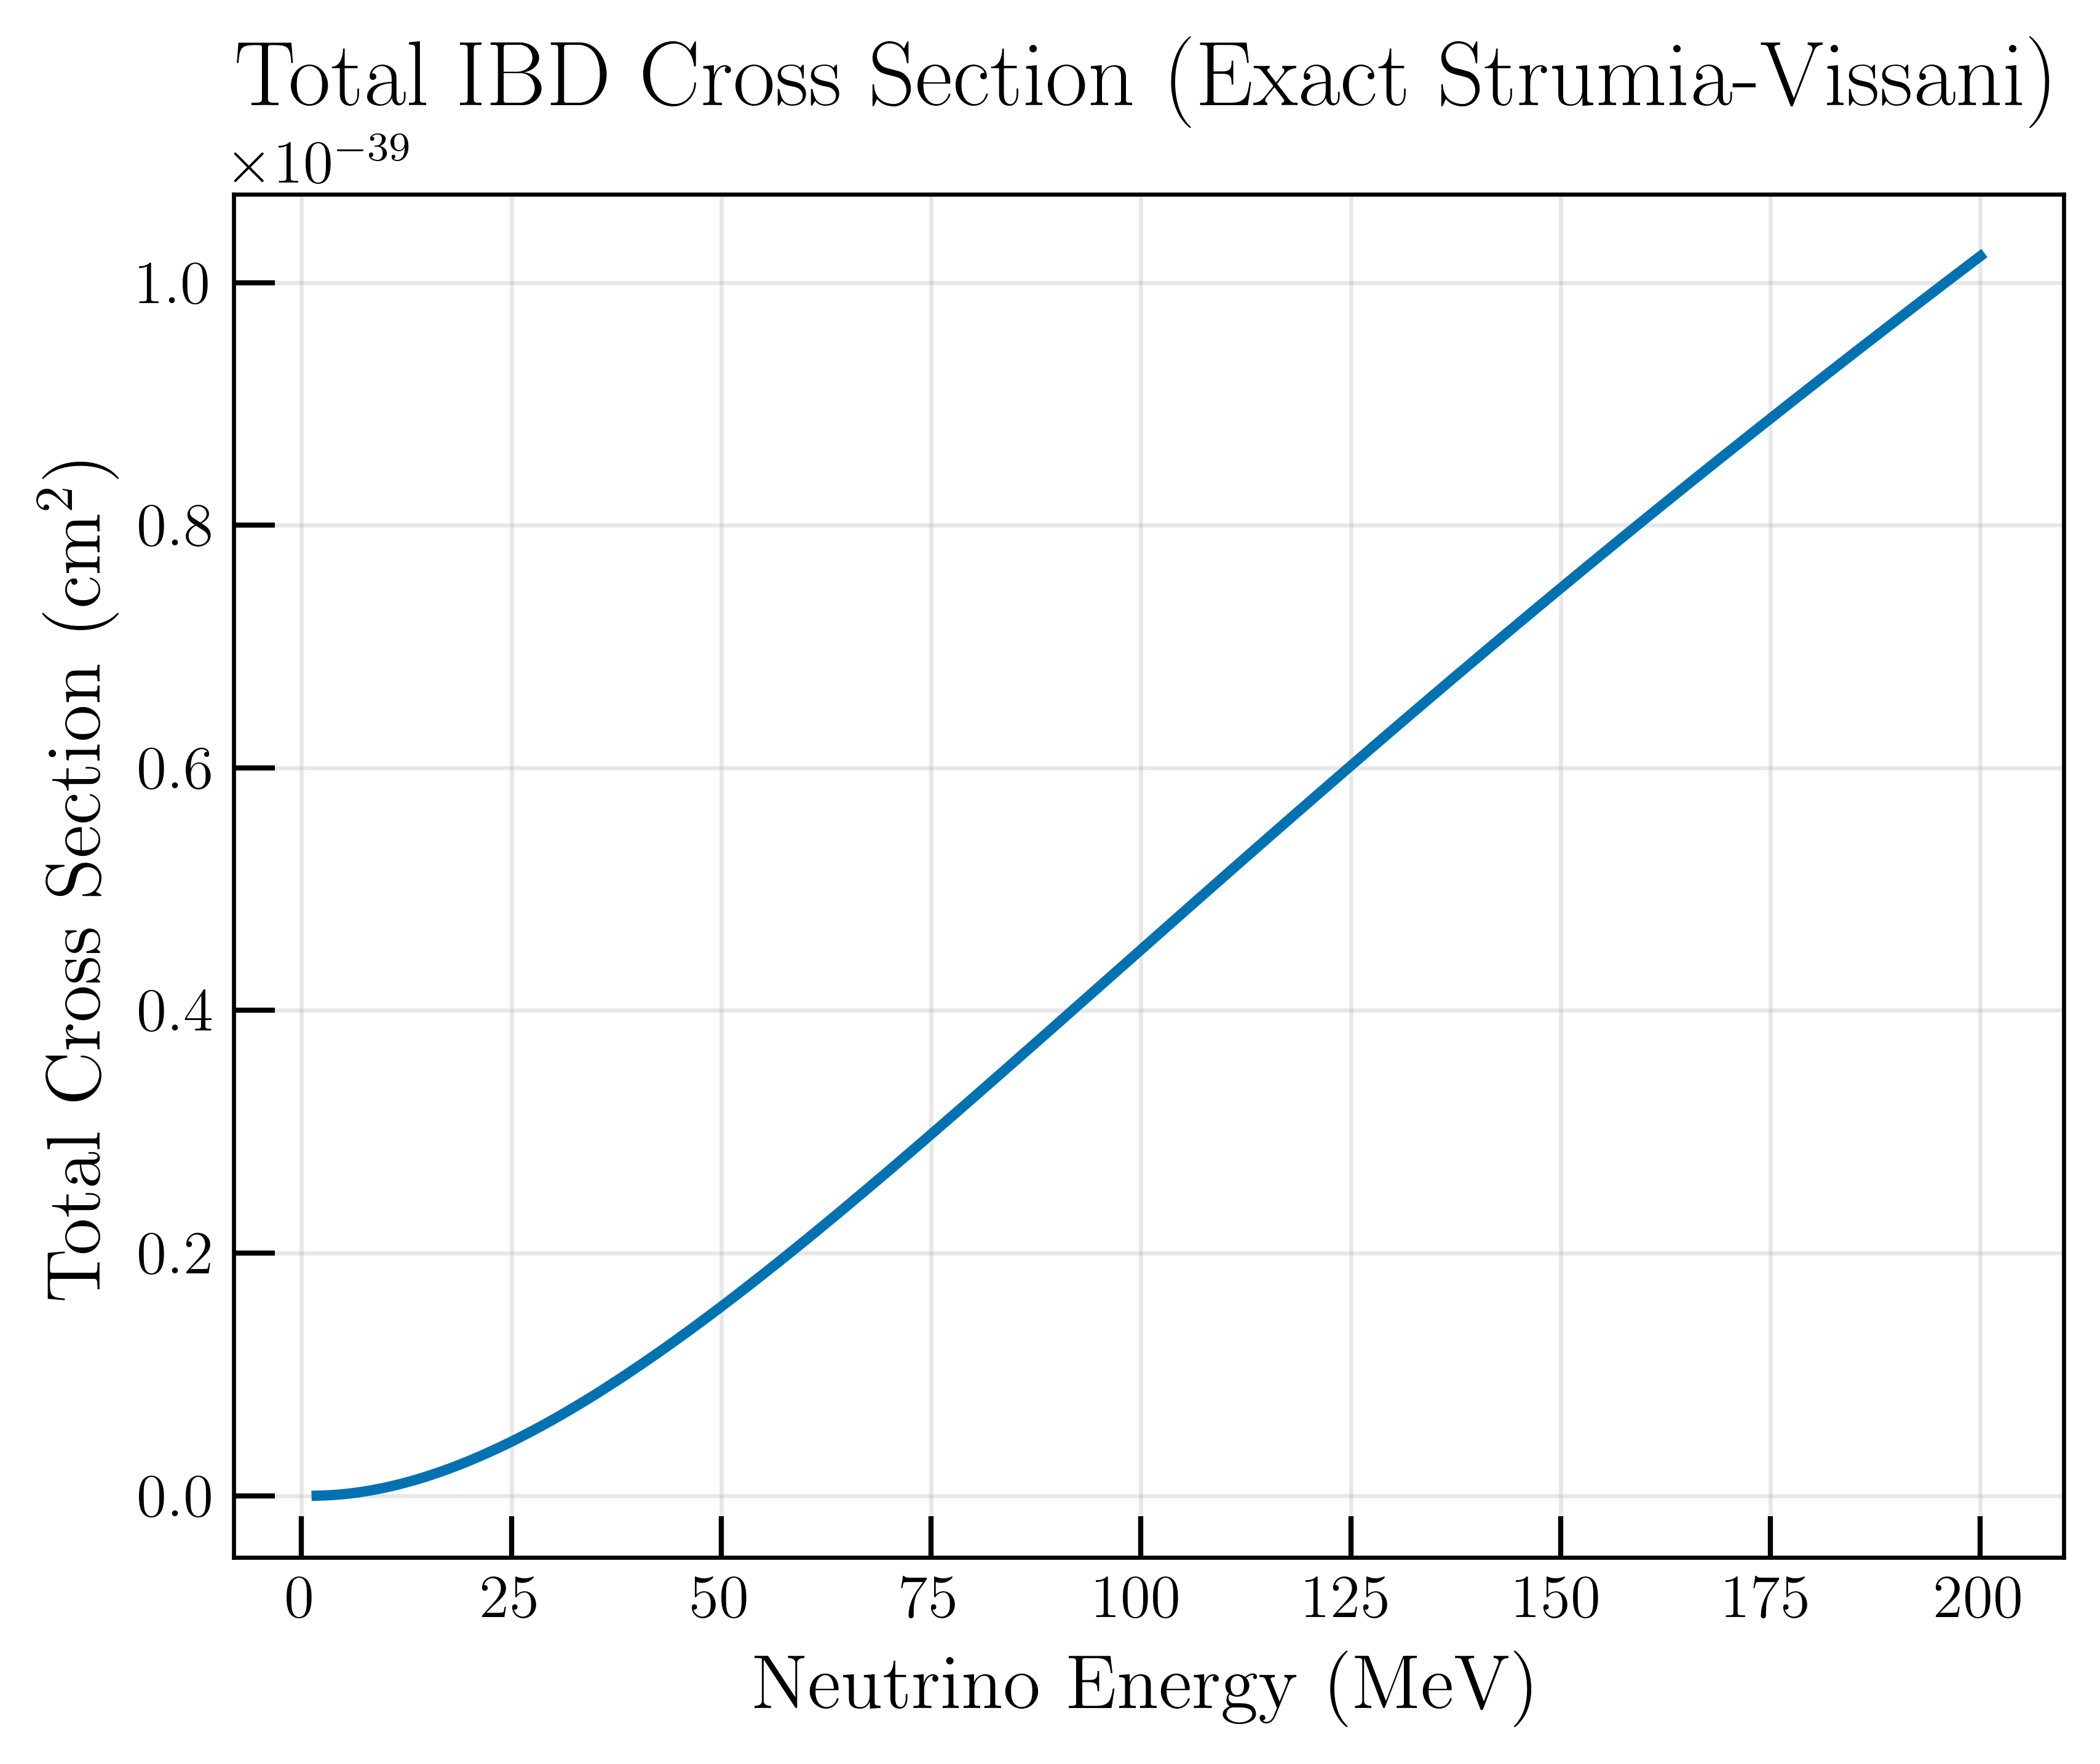

In [5]:
# Total cross section example
# This should match Fig. 1 in Strumia-Vissani paper
test_energies = np.linspace(1.8, 200, 200)
total_cross_sections = [sv_exact.get_total_cross_section(E) for E in test_energies]
# plt.figure(figsize=(8,5))
plt.plot(test_energies, total_cross_sections)
# plt.yscale('log')
plt.xlabel("Neutrino Energy (MeV)")
plt.ylabel("Total Cross Section (cm$^2$)")
plt.title("Total IBD Cross Section (Exact Strumia-Vissani)")
plt.grid(True, alpha=0.3)
plt.show()

A few more evaluations. I found that the total cross sections near threshold are ~2% different from the Strumia-Vissani paper, but the cross section is very small there so it should not cause too much error.

In [6]:
sv_exact.get_total_cross_section(1.8057)

array([0.])

In [7]:
sv_exact.get_total_cross_section(2.01)

array([3.43684109e-44])

I also checked the radiative correction formula against the original Kurylov paper. They agree very well.

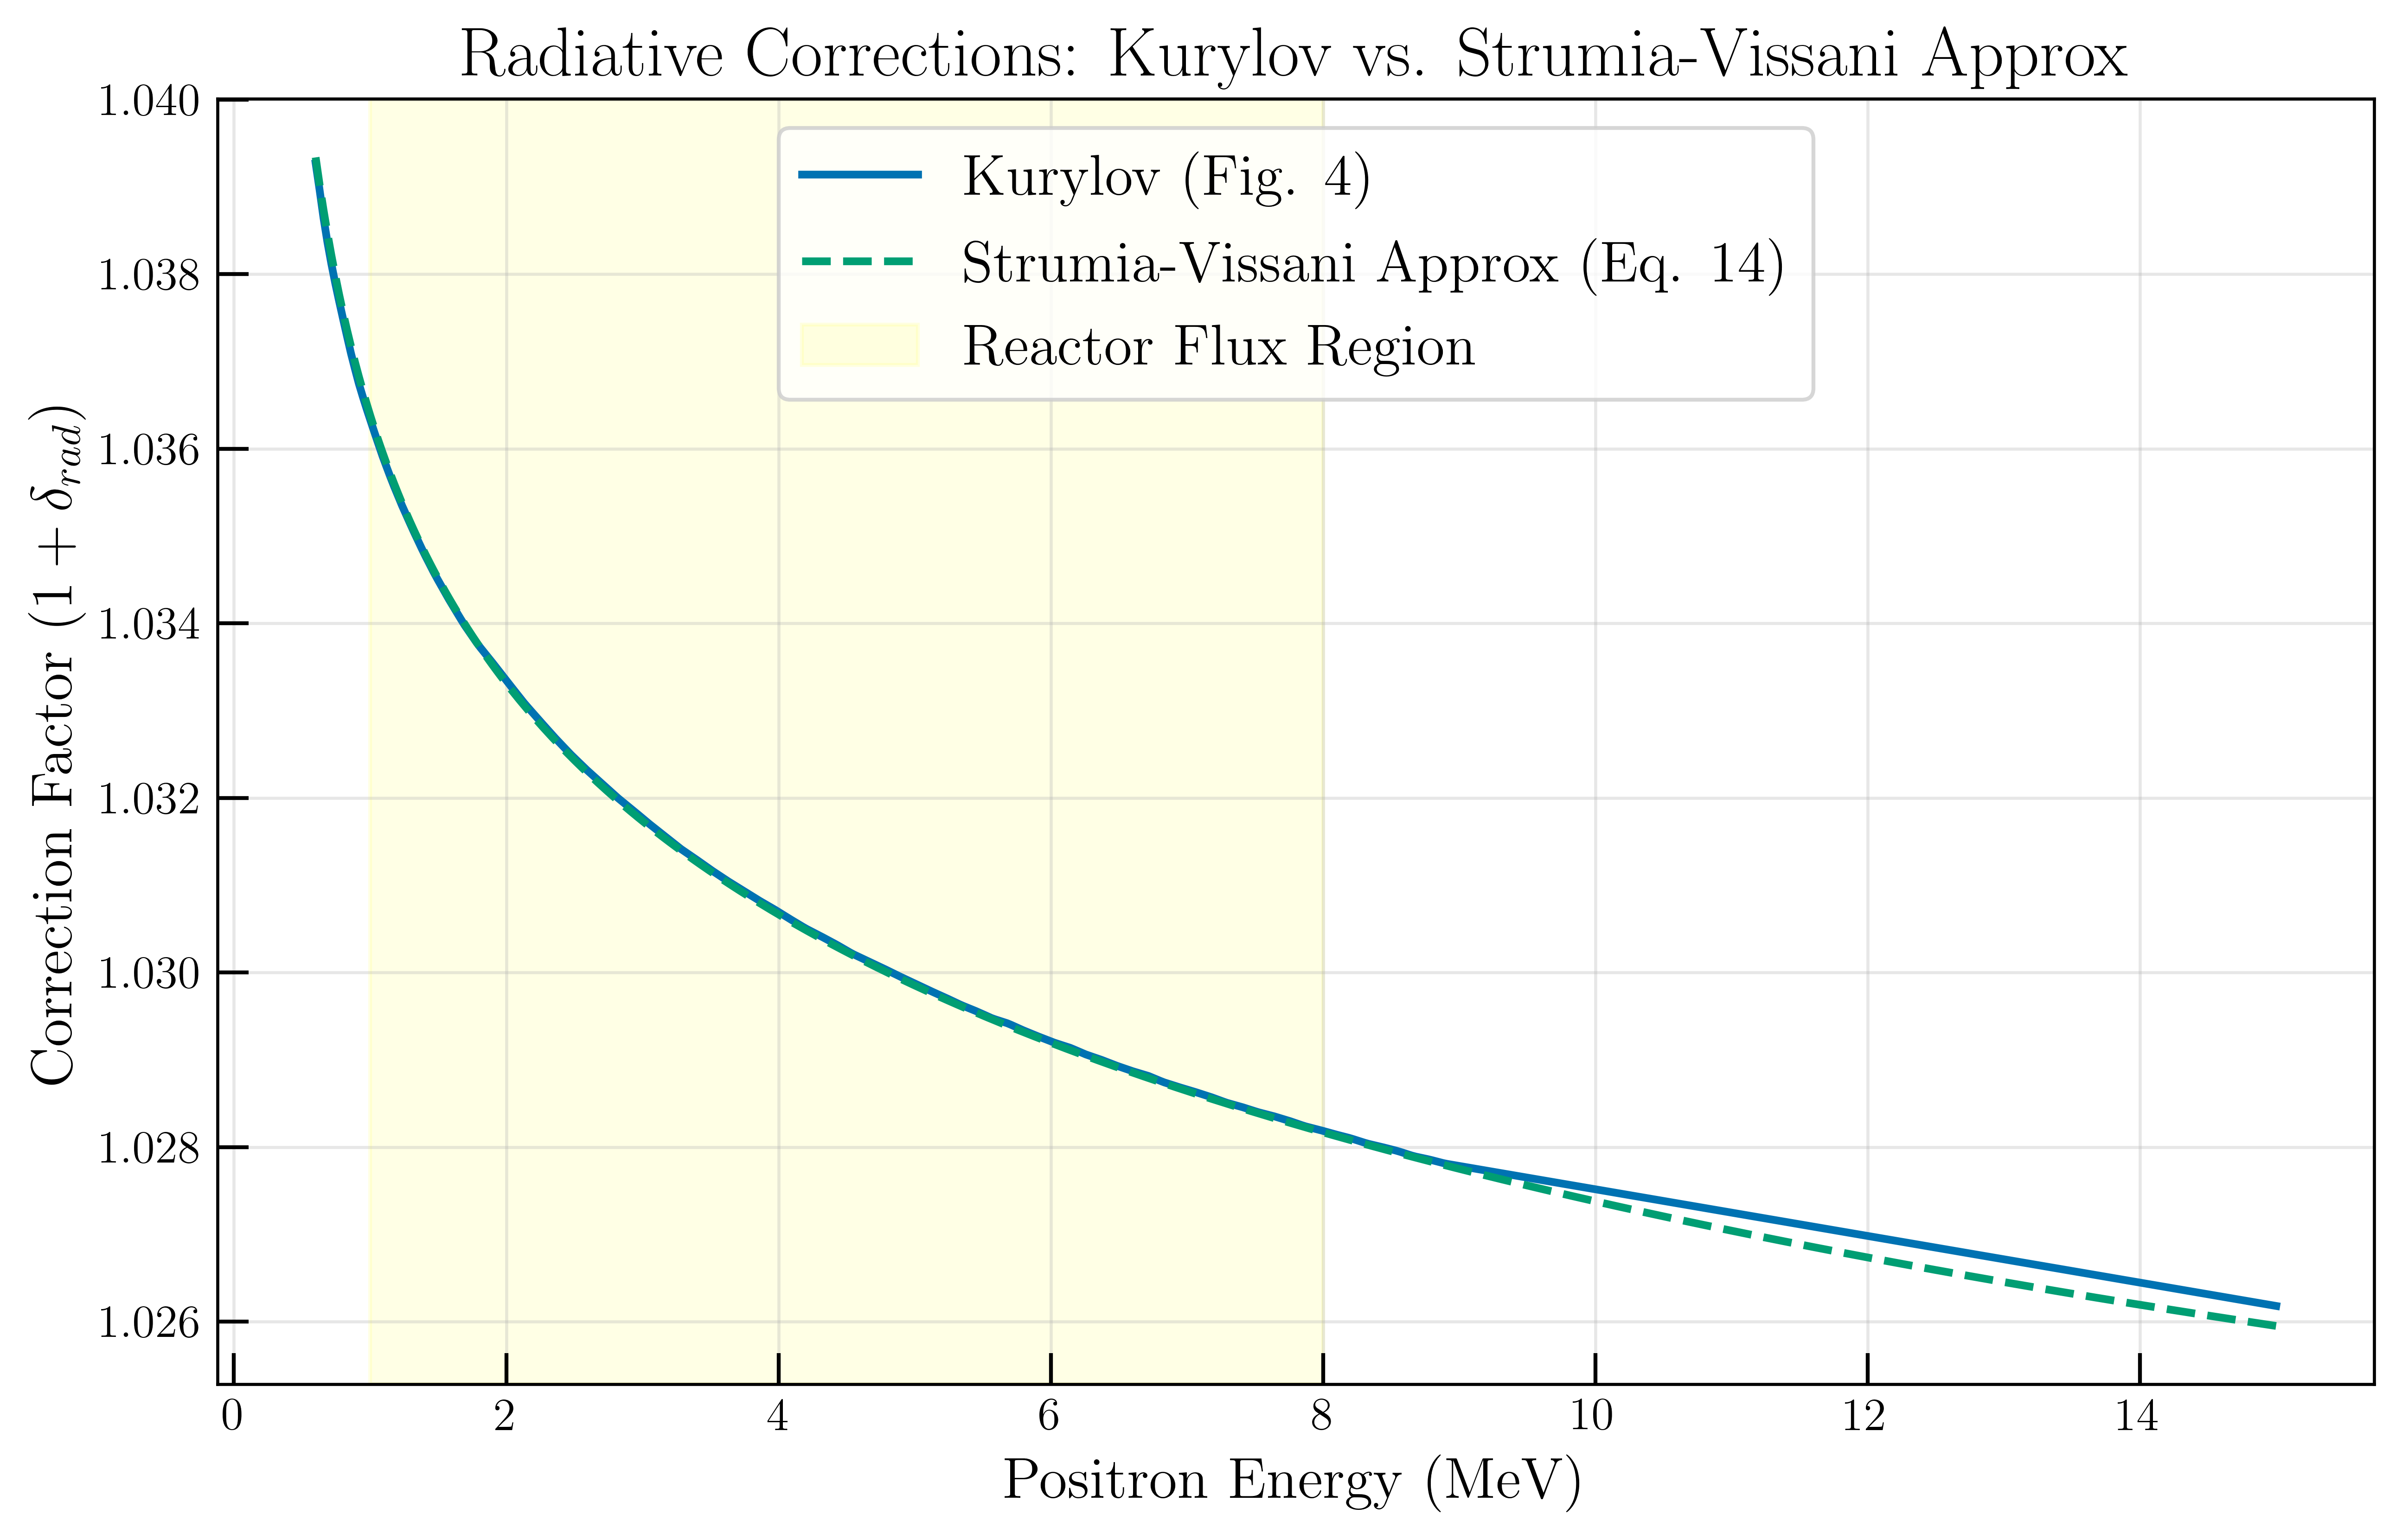

At 5.0 MeV, Difference = 0.002%


In [8]:
import numpy as np
import matplotlib.pyplot as plt


def rad_strumia_vissani_approx(E_e):
    """
    The simple approximation from Strumia-Vissani Eq. 14.
    Valid for E_e < 100 MeV.
    """
    alpha = 1.0 / 137.036
    m_p = 938.272
    m_e = 0.511

    # SV Eq 14
    term_log = 1.5 * np.log(m_p / (2 * E_e))
    term_lowE = 1.2 * (m_e / E_e) ** 1.5
    delta = (alpha / np.pi) * (6.0 + term_log + term_lowE)
    return 1.0 + delta


def rad_kurylov(E_e):
    corr_file = np.loadtxt("./data/kurylov_radiative_correction.csv", delimiter=",")
    interp = scipy.interpolate.interp1d(
        corr_file[:, 0],
        corr_file[:, 1] / 100 + 1.0,
        kind="linear",
        fill_value="extrapolate",
    )
    return interp(E_e)


energies = np.linspace(0.6, 15.0, 500)  # Reactor Range
kurylov_vals = np.array([rad_kurylov(e) for e in energies])
sv_vals = np.array([rad_strumia_vissani_approx(e) for e in energies])

plt.figure(figsize=(10, 6))

plt.plot(energies, kurylov_vals, label="Kurylov (Fig. 4)", linewidth=2)
plt.plot(energies, sv_vals, "--", label="Strumia-Vissani Approx (Eq. 14)", linewidth=2)

# Highlight the JUNO Region
plt.axvspan(1, 8, color="yellow", alpha=0.1, label="Reactor Flux Region")

plt.title("Radiative Corrections: Kurylov vs. Strumia-Vissani Approx")
plt.xlabel("Positron Energy (MeV)")
plt.ylabel("Correction Factor $(1 + \delta_{rad})$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Check difference at 5 MeV
e_check = 5.0
diff = 100 * (rad_kurylov(e_check) - rad_strumia_vissani_approx(e_check))
print(f"At {e_check} MeV, Difference = {diff:.3f}%")